# Various figures dealing with latlon mapping through cartopy

### These do not seem to work on NCI
 - could be due to firewall not wanting to download data
 - may be able to store commonly used features/maps somewhere
 
### Figures include fire outlines, area outlines, and nested gridding
 - Fire outlines can hopefully be added through shape file readings, but may need to create a manual list of latlons
 - google maps can be used to show suburbs that are fire affected
 - stamen maps are something between a satellite photo and a contour map

In [1]:
# Show plots in the browser
%matplotlib inline
#%matplotlib notebook

import matplotlib as mpl
import matplotlib.colors as col
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib.patches as mpatches
import numpy as np
from netCDF4 import Dataset
# mapping libraries
import cartopy
import cartopy.feature as cpf
# geometry to add onto cartopy
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.transforms import offset_copy
# helper package for dealing with indices or cross sections etc
# repeated stuff in this notebook will probably be refactored to the utils or plotting package
from utilities import utils, fio, constants, plotting
# Plot defaults
plotting.init_plots()

##### Show the map of Waroona

Nearby terrain shown along with synoptic region inset for context

Perth and Waroona shown on the map too


C:\Users\jgreensl\AppData\Local\conda\conda\envs\BOMenv\lib\site-packages\cartopy\mpl\geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000002620212F648> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


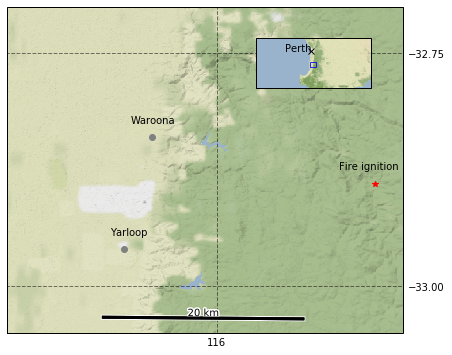

In [3]:



fig = plt.figure(figsize=[8,6])
# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=proj)#stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(extents['waroona'], crs=proj)

# Add the Stamen data at zoom level 14.
ax.add_image(stamen_terrain, 11)

# Grid lines and labels
gl = ax.gridlines(crs=proj, linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylabels_right=True
gl.xlines = True
gl.xlocator = mpl.ticker.FixedLocator(np.arange(110,120,0.25))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(-40,-10,0.25))

# Add a marker for waroona. LON, LAT, ... argument order important!
plotting.map_add_locations(['waroona','yarloop'], text=['Waroona','Yarloop'], proj=proj,
                          marker='o', color='grey',textcolor='k')
plotting.map_add_locations(['fire_waroona'], text=['Fire ignition'], proj=proj,
                          marker='*', color='red',textcolor='k')

# Add scale
plotting.scale_bar(ax,proj,20)

# Show synoptic area for reference
sub_ax = plt.axes([0.60, 0.65, 0.2, 0.2], projection=proj)
sub_ax.set_extent(extents['waroonas'], crs=proj)

# Add the Stamen data.
sub_ax.add_image(stamen_terrain, 7)

# Add Perth
plotting.map_add_locations(['perth'],text=['Perth'], proj=proj,
                           marker='x', color='k', markersize=3)

# add lat,lon boundaries as area marker
drawbox=extents['waroona']
gl2 = sub_ax.gridlines(crs=proj, linewidth=1, color='blue', alpha=0.8, linestyle='-', draw_labels=False)
gl2.xlocator = mpl.ticker.FixedLocator([drawbox[0],drawbox[1]])
gl2.ylocator = mpl.ticker.FixedLocator([drawbox[2],drawbox[3]])

plt.show()

## Similar view but showing topography, and google map

drawing grid


C:\Users\jgreensl\AppData\Local\conda\conda\envs\BOMenv\lib\site-packages\cartopy\mpl\geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000001EEADE46288> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))
C:\Users\jgreensl\AppData\Local\conda\conda\envs\BOMenv\lib\site-packages\cartopy\mpl\geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000001EEAE595B28> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


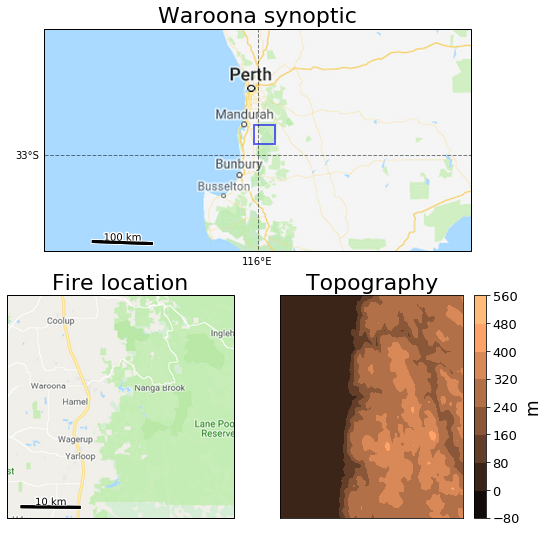

In [3]:

topog,latt,lont = fio.read_topog()

# Google map image tiles view of synoptic map
fig = plt.figure(figsize=[9,9])
_,ax,mproj=plotting.map_google(extents['waroonas'],
                              zoom=6,
                              fig=fig,
                              subplotxyn=[2,1,1],
                              gridlines=[np.arange(-51,-10,2),
                                         np.arange(100,150,4)
                                        ]
                             )
plt.title("Waroona synoptic")
## Add box around zoomed in area
ax.add_patch(mpatches.Rectangle(xy=latlons['waroona'][::-1], 
                                width=.4, 
                                height=.3,
                                #facecolor=None,
                                fill=False,
                                edgecolor='blue',
                                linewidth=2,
                                #linestyle='-',
                                alpha=0.6, 
                                transform=ccrs.PlateCarree()
                               )
            )
## add text?

## Add scale
scaleloc=(0.2,0.05)
plotting.scale_bar(ax,proj,100, location=scaleloc)


## Look at waroona and yarloop
_,ax2,mproj = plotting.map_google(extents['waroona'],zoom=10,fig=fig,subplotxyn=[2,2,3],draw_gridlines=False)
# This crashes the kernal for some reason..
#lotting.map_add_locations(['fire_waroona'], text=['Fire ignition'], proj=mproj,
#                          marker='*', color='red',textcolor='k')
plt.title("Fire location")

## Add scale
plotting.scale_bar(ax2,mproj,10, location=scaleloc)

## Add contour plot showing topography
plt.subplot(2,2,4)
plotting.map_topography(extents['waroona'], topog,latt,lont)

plt.show()

## Plot winds at surface and high troposphere

Quiver for horizontal winds, contour to show vertical windspeed

Add coastlines to map for context

In [7]:
## READ THE OLD WAROONA FILE
data=fio.read_waroona_old([fio._files_waroona_old_[0]])
print(data.keys)
print(data['zth'].shape)

INFO: Reading  data/waroona\umnsaa_pc2016010515.nc  ... 
INFO: finished reading  data/waroona\umnsaa_pc2016010515.nc


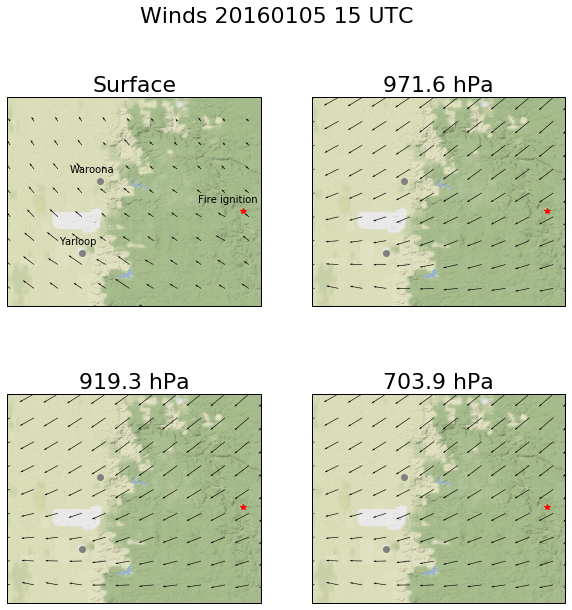

In [21]:


lat=data['latitude']
lon=data['longitude']

tstep=0
p=data['air_pressure'][tstep]
u=data['x_wind_destaggered'][tstep]
v=data['y_wind_destaggered'][tstep]

dtime=utils.date_from_gregorian(data['time'])[0]
tstamp = dtime.strftime("%Y%m%d %H UTC")

# Reduce resolution by skipping n-1 datapoints in every n
skiplen = 10
skip=(slice(None,None,skiplen),slice(None,None,skiplen))
latlr = lat[::skiplen]
lonlr = lon[::skiplen]
usurflr = u[0][skip]
vsurflr = v[0][skip]
zlev=65
uhighlr = u[zlev][skip] # higher altitude winds
vhighlr = v[zlev][skip]
arrowscale=70 # smaller number makes arrows huge in quiver plot

fig = plt.figure(figsize=[10,10])
# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(2, 2, 1, projection=proj)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(extents['waroona'], crs=proj)

# Add the Stamen data at zoom level 11.
ax.add_image(stamen_terrain, 11)
# add waroona, yarloop, fire start
plotting.map_add_locations(['waroona','yarloop'], proj=proj, text=['Waroona', 'Yarloop'])
plotting.map_add_locations(['fire_waroona'], proj=proj, text=['Fire ignition'], marker='*',color='r')
plt.title("Surface")
# PLOT THE QUIVER WITH WINDS
plt.quiver(lonlr, latlr, usurflr, vsurflr, zorder=2,color='k', scale=arrowscale)


# Plot higher winds too
for i,zlev in enumerate([15,30,65]):
    ax2 = fig.add_subplot(2, 2, i+2, projection=proj)

    # Limit the extent of the map to a small longitude/latitude range.
    ax2.set_extent(extents['waroona'], crs=proj)

    # Add the Stamen data at zoom level 14.
    ax2.add_image(stamen_terrain, 11)
    # add waroona, yarloop, fire start
    plotting.map_add_locations(['waroona','yarloop'], proj=proj, text=['', ''])
    plotting.map_add_locations(['fire_waroona'], proj=proj, text=[''], marker='*',color='r')

    # quiver at higher altitude
    plt.title("%.1f hPa"%np.nanmean(p[zlev]/100.))
    plt.quiver(lonlr, latlr, uhighlr, vhighlr, zorder=2,color='k',scale = arrowscale)

plt.suptitle("Winds %s"%tstamp,fontsize=22)
plt.show()

## Show nested grids and maybe fire extent

#### Nested grids
 - Made with mpatches, annotated in corners
 - resolution shown as legend

#### Fire extent ideally from shape files QGIS output
 - Overlaid on a zoomed in map I think is best


drawing grid


C:\Users\jgreensl\AppData\Local\conda\conda\envs\BOMenv\lib\site-packages\cartopy\mpl\geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000001BC81520048> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


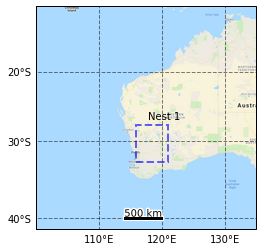

ModuleNotFoundError: No module named 'fiona'

In [27]:
# Area including nested grid bounds
extent = [100,135,-40,-10]

fig = plt.figure(figsize=[10,9])
_, ax, gproj = plotting.map_google(extent, fig=fig, zoom=5 ,subplotxyn=[2,1,1],gridlines=[np.arange(-90,90,10),np.arange(-180,180,10)])

# Add scale
plotting.scale_bar(ax,gproj,500)


## Add boxes for nested grids
centre=latlons['waroona']
h1,w1 = 5,5
ax.add_patch(mpatches.Rectangle(xy=centre[::-1], 
                                width=5, 
                                height=5,
                                #facecolor=None,
                                fill=False,
                                edgecolor='blue',
                                linewidth=2,
                                linestyle='--',
                                alpha=0.6, 
                                transform=ccrs.PlateCarree()))

transform = ccrs.PlateCarree()._as_mpl_transform(ax)
ax.annotate('Nest 1', xy=(centre[1]+2+w1, centre[0]+2+h1), xycoords=transform,
            ha='right', va='top')
plt.show()


#Read shape file
import fiona
fpath = "data/waroona/Isochrones_merged_sort_20160308.shp"
## NEED .shx and .dbf files to use this shape file

shape = fiona.open(fpath)
print (shape.schema)
##{'geometry': 'LineString', 'properties': OrderedDict([(u'FID', 'float:11')])}
##first feature of the shapefile
#first = next(iter(shape))
#print(first)# (GeoJSON format)
##{'geometry': {'type': 'LineString', 'coordinates': [(0.0, 0.0), (25.0, 10.0), (50.0, 50.0)]}, 'type': 'Feature', 'id': '0', 'properties': OrderedDict([(u'FID', 0.0)])}
#for item in iter(shape):
#    print("============")
#    print(item)


